In [ ]:
# 시퀀스 2 시퀀스 모델 활용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import os
os.chdir('/content/drive/MyDrive/chatbot')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 49.9 MB/s eta 0:00:00


In [ ]:
from preprocess import *

In [ ]:
# 시각화 함수 생성
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
!pwd

/content/drive/MyDrive/chatbot


In [ ]:
# 해당 폴더가 없을때 실행
# !mkdir data_out

In [ ]:
# 학습 데이터 경로 정의

DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [ ]:
# 랜덤값 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [ ]:
# 미리 전처리된 학습에 필요한 데이터와 설정값 불러오기

index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [ ]:
# 배열의 크기 확인하기
print(len(index_inputs), len(index_outputs), len(index_targets))

51628 51628 51628


In [ ]:
# 모델 구성에 필요한 값 선언하기

MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 100
MAX_SEQUENCE = 25
EPOCH = 50
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

In [ ]:
# 시퀀스 투 시퀀스 모델의 인코더

class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state = True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

In [ ]:
# 어텐션 소스코드 생성

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    
        attention_weights = tf.nn.softmax(score, axis = 1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [ ]:
# 디코더 소스 작성하기
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()

        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences =True, return_state = True, recurrent_initializer = 'glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        self.attention = BahdanauAttention(self.dec_units)


    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights


In [ ]:
# 손실함수와 정확도 측정 함수

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis= -1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [ ]:
# seq2seq 클래스(각 분리된 클래스를 이어주는 메인 클래스)

class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx = 2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)

    def call(self, x):
        inp, tar = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
        
        return tf.stack(predict_tokens, axis = 1)


    def inference(self, x):
        inp = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([char2idx[std_index]], 1)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])

            if predict_token == self.end_token_idx:
                break
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)
        
        return tf.stack(predict_tokens, axis = 0).numpy()

In [ ]:
# 모델 만들기 (seq2seq 객체 생성)
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

In [ ]:
# 학습 진행하기

PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets, batch_size = BATCH_SIZE, epochs=EPOCH, 
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])


Epoch 1/100
930/930 [==============================] - ETA: 0s - loss: 1.2025 - accuracy: 0.8191
Epoch 1: val_accuracy improved from -inf to 0.83175, saving model to ./data_out/seq2seq_kor/weights.h5
930/930 [==============================] - 319s 293ms/step - loss: 1.2025 - accuracy: 0.8191 - val_loss: 0.9736 - val_accuracy: 0.8317
Epoch 2/100
930/930 [==============================] - ETA: 0s - loss: 1.0249 - accuracy: 0.8350
Epoch 2: val_accuracy improved from 0.83175 to 0.83746, saving model to ./data_out/seq2seq_kor/weights.h5
930/930 [==============================] - 267s 287ms/step - loss: 1.0249 - accuracy: 0.8350 - val_loss: 0.8912 - val_accuracy: 0.8375
Epoch 3/100
930/930 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.8390
Epoch 3: val_accuracy improved from 0.83746 to 0.84014, saving model to ./data_out/seq2seq_kor/weights.h5
930/930 [==============================] - 274s 294ms/step - loss: 0.9427 - accuracy: 0.8390 - val_loss: 0.8397 - val_accura

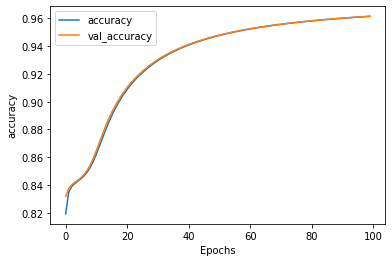

In [ ]:
# 평가 정확도 시각화 그래프
plot_graphs(history, 'accuracy')

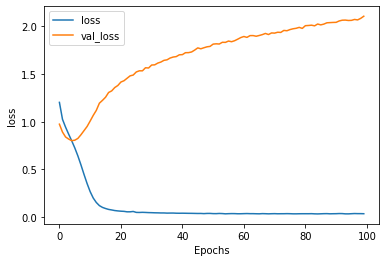

In [ ]:
# 평가 손실값 시각화 그래프
plot_graphs(history, 'loss')

In [ ]:
# 학습이 잘 되었는지 확인하기
query = '슬프다'

test_index_inputs, _ = enc_processing([query], char2idx)
# print(test_index_inputs)

predict_tokens = model.inference(test_index_inputs)
# print(predict_tokens)
print(' '.join([ idx2char[f'{t}'] for t in predict_tokens ]))

<UNK> 일이 <UNK>


In [ ]:
# 학습이 잘 되었는지 확인하기
query = '오늘 나 너무 기쁜 일이 있었어! 백수로 계속 지내다가 드디어 취업을 했어!'

test_index_inputs, _ = enc_processing([query], char2idx)
# print(test_index_inputs)

predict_tokens = model.inference(test_index_inputs)
# print(predict_tokens)
print(' '.join([ idx2char[f'{t}'] for t in predict_tokens ]))

기쁜 일이 <UNK> <UNK>


In [ ]:
# 학습이 잘 되었는지 확인하기
query = '네가 자꾸 그렇게 얘기하면 나는 너무 화가 나!'

test_index_inputs, _ = enc_processing([query], char2idx)
# print(test_index_inputs)

predict_tokens = model.inference(test_index_inputs)
# print(predict_tokens)
print(' '.join([ idx2char[f'{t}'] for t in predict_tokens ]))

다른 <UNK> 대해 <UNK> 것 같아요


# 모델 저장하기

# 모델 로드할때는 에폭 한번 돌리고 나서 로드해야 불러와짐

In [ ]:
# # 저장된 모델 로드하기
# SAVE_FILE_NM = "weights.h5"
# # print(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))
# model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))
# # model.load_weights('/content/drive/MyDrive/chatbot/data_out/seq2seq_kor/sp_weights.h5')